In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [2]:
import os
import torch
import clip
import numpy as np
import pandas as pd
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt


C:\Users\samyu\Desktop\kiosk\kiosk\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define data directory and file paths
data_dir = "../data"  # Adjust path as needed
classes_file = os.path.join(data_dir, "classes.txt")
attributes_file = os.path.join(data_dir, "predicates.txt")

# Load classes
with open(classes_file, "r") as f:
    classes = [line.split("\t")[1].strip() for line in f.readlines()]

# Load attributes
with open(attributes_file, "r") as f:
    attributes = [line.split("\t")[1].strip() for line in f.readlines()]

# Load attribute matrix
# Load attribute matrix with continuous values (assuming it's formatted correctly)
attribute_matrix_file = os.path.join(data_dir, "predicate-matrix-continuous.txt")

attribute_matrix = pd.read_csv(attribute_matrix_file, sep=r'\s+', header=None)
attribute_matrix.columns = attributes
attribute_matrix.index = classes

# Check the matrix
print(f"Attribute Matrix Shape: {attribute_matrix.shape}")
print(attribute_matrix.head())


# Check loaded data
print(f"Loaded {len(classes)} classes and {len(attributes)} attributes.")
print("Sample Classes:", classes[:5])
print("Sample Attributes:", attributes[:5])
print(f"Attribute Matrix Shape: {attribute_matrix.shape}")
pd.to_pickle(attribute_matrix, "attribute_matrix.pkl")


Attribute Matrix Shape: (50, 85)
              black  white  blue  brown   gray  orange  red  yellow  patches  \
antelope      -1.00  -1.00  -1.0  -1.00  12.34     0.0  0.0     0.0    16.11   
grizzly+bear  39.25   1.39   0.0  74.14   3.75     0.0  0.0     0.0     1.25   
killer+whale  83.40  64.79   0.0   0.00   1.25     0.0  0.0     0.0    68.49   
beaver        19.38   0.00   0.0  87.81   7.50     0.0  0.0     0.0     0.00   
dalmatian     69.58  73.33   0.0   6.39   0.00     0.0  0.0     0.0    37.08   

               spots  ...  water  tree   cave  fierce  timid  smart  group  \
antelope        9.19  ...   0.00  0.00   1.23   10.49  39.24  17.57  50.59   
grizzly+bear    0.00  ...   7.64  9.79  53.14   61.80  12.50  24.00   3.12   
killer+whale   32.69  ...  79.49  0.00   0.00   38.27   9.77  52.03  24.94   
beaver          7.50  ...  65.62  0.00   0.00    3.75  31.88  41.88  23.44   
dalmatian     100.00  ...   1.25  6.25   0.00    9.38  31.67  53.26  24.44   

              sol

In [4]:
# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
model_clip, preprocess = clip.load("ViT-B/32", device=device)


In [5]:
# Generate class embeddings
def generate_class_embeddings(classes):
    class_embeddings = {}
    with torch.no_grad():
        for class_name in classes:
            text_tokens = clip.tokenize([class_name]).to(device)
            embedding = model_clip.encode_text(text_tokens).cpu().numpy()
            class_embeddings[class_name] = embedding
    return class_embeddings

class_embeddings = generate_class_embeddings(classes)
torch.save(class_embeddings, "class_embeddings.pt")


In [6]:
# Generate attribute embeddings
def attribute_to_embedding_incremental(attributes, attribute_matrix, threshold=50, max_tokens=77):
    attribute_embeddings = {}
    with torch.no_grad():
        for index, class_name in enumerate(attribute_matrix.index):
            # Retrieve the class's attribute vector
            attribute_vector = attribute_matrix.iloc[index]

            # Select attributes based on the threshold (ignore -1 values)
            selected_attributes = [
                attributes[i] for i, val in enumerate(attribute_vector) if val >= threshold and val != -1
            ]

            # Tokenize selected attributes
            tokenized_attributes = {attr: clip.tokenize([attr])[0] for attr in selected_attributes}

            valid_attributes = []
            total_tokens = 0
            for attr, tokens in tokenized_attributes.items():
                if total_tokens + len(tokens) <= max_tokens:
                    valid_attributes.append(attr)
                    total_tokens += len(tokens)
                else:
                    break

            # Create a descriptive sentence for the attributes
            attribute_description = f"This animal is described as {', '.join(valid_attributes)}."
            text_tokens = clip.tokenize([attribute_description]).to(device)
            embedding = model_clip.encode_text(text_tokens).cpu().numpy()
            attribute_embeddings[class_name] = embedding
    return attribute_embeddings




attribute_embeddings = attribute_to_embedding_incremental(attributes, attribute_matrix)
torch.save(attribute_embeddings, "attribute_embeddings.pt")


In [7]:
# Combine embeddings
def align_embeddings(class_embeddings, attribute_embeddings):
    combined_embeddings = {}
    for class_name in class_embeddings.keys():
        visual_emb = class_embeddings[class_name]
        text_emb = attribute_embeddings[class_name]
        
        # Combine embeddings (keeping visual and attribute embeddings separate or modifying based on continuous data)
        combined_emb = np.concatenate((visual_emb, text_emb), axis=1)  # This is fine for now

        combined_embeddings[class_name] = combined_emb
    return combined_embeddings

combined_embeddings = align_embeddings(class_embeddings, attribute_embeddings)
visual_embeddings = {class_name: embedding.flatten()[:512] for class_name, embedding in combined_embeddings.items()}


In [8]:
# Image embedding function
def generate_image_embedding(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model_clip.encode_image(image).cpu().numpy().flatten()
    return image_embedding

# Zero-shot classification
def zero_shot_classification(image_embedding, visual_embeddings, class_names):
    similarities = []
    for class_name, visual_embedding in visual_embeddings.items():
        # Calculate cosine similarity
        similarity = np.dot(image_embedding, visual_embedding) / (
            np.linalg.norm(image_embedding) * np.linalg.norm(visual_embedding)
        )
        similarities.append((class_name, similarity))

    return sorted(similarities, key=lambda x: x[1], reverse=True)[0]



In [9]:
def get_active_attributes(normalized_attribute_matrix, attributes, class_name, threshold=50):
    class_index = attribute_matrix.index.get_loc(class_name)
    attribute_vector = attribute_matrix.iloc[class_index]
    
    # Include only attributes with a value above the threshold
    active_attributes = [attributes[i] for i in range(len(attribute_vector)) if attribute_vector.iloc[i] >= threshold]
    
    return active_attributes


In [10]:
from langchain.prompts import PromptTemplate
from langchain.llms import CTransformers

def getLLamaresponse(input_text,no_words,blog_style):

    ### LLama2 model
    llm=CTransformers(model='../models/llama-2-7b-chat.ggmlv3.q8_0.bin',
                      model_type='llama',
                      config={'max_new_tokens':256,
                              'temperature':0.01})
    
    ## Prompt Template

    template = """
    Write an engaging blog in {blog_style} style answering the question "{input_text}"
    in approximately 50 words. The content should be written for a general audience 
    and focus on storytelling and information sharing.
        """

    
    prompt=PromptTemplate(input_variables=["blog_style","input_text",'no_words'],
                          template=template)
    
    ## Generate the ressponse from the LLama 2 model
    response=llm(prompt.format(blog_style=blog_style,input_text=input_text,no_words=no_words))
    print(response)



In [11]:
import json
# Load the categorized attributes
with open("categorized_attributes.json", "r") as file:
    categorized_attributes = json.load(file)

# Example: Access attributes for a specific category
physical_features = categorized_attributes["Physical Traits"]
print(f"Physical Features: {physical_features}")


Physical Features: ['big', 'lean', 'furry', 'tail', 'paws', 'meatteeth', 'claws', 'longleg', 'muscle', 'quadrupedal', 'agile', 'strong', 'large', 'robust', 'small', 'sleek', 'broad']


Predicted Class: antelope, Similarity Score: 0.3032
Attributes for antelope: ['hooves', 'longleg', 'horns', 'walks', 'fast', 'quadrapedal', 'agility', 'vegetation', 'grazer', 'oldworld', 'plains', 'ground', 'group']


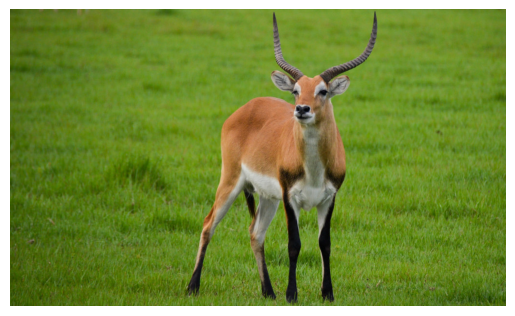

Categorized Active Attributes for antelope:
Physical Traits: ['longleg']
Behavior: ['fast', 'agility']
Habitat: ['plains', 'ground']
Diet: ['grazer']
Other Characteristics: ['oldworld']


In [12]:
# Main execution
image_path = "../data/images/antelope/antelope_10019.jpg"  # Update this with your image path
image_embedding = generate_image_embedding(image_path)

predicted_class, score = zero_shot_classification(image_embedding, visual_embeddings, classes)
print(f"Predicted Class: {predicted_class}, Similarity Score: {score:.4f}")


active_attributes = get_active_attributes(attribute_matrix, attributes, predicted_class)
print(f"Attributes for {predicted_class}: {active_attributes}")

# Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Categorize active attributes
active_attributes_categorized = {
    category: [attr for attr in active_attributes if attr in attributes]
    for category, attributes in categorized_attributes.items()
}

# Print categorized active attributes
print(f"Categorized Active Attributes for {predicted_class}:")
for category, attrs in active_attributes_categorized.items():
    if attrs:  # Only show categories with active attributes
        print(f"{category}: {attrs}")



In [13]:

# Filter and sort active attributes within each category
class_index = attribute_matrix.index.get_loc(predicted_class)
class_values = attribute_matrix.iloc[class_index]

# Categorize and sort attributes
sorted_active_attributes_categorized = {}
for category, attributes_in_category in categorized_attributes.items():
    # Find active attributes in the current category
    active_attrs_in_category = [
        attr for attr in active_attributes if attr in attributes_in_category
    ]
    
    # Sort active attributes by their values in the continuous matrix
    sorted_active_attrs = sorted(
        active_attrs_in_category, 
        key=lambda attr: class_values[attr], 
        reverse=True
    )
    
    if sorted_active_attrs:  # Only include non-empty categories
        sorted_active_attributes_categorized[category] = sorted_active_attrs

# Print sorted categorized active attributes
print(f"Sorted Categorized Active Attributes for {predicted_class}:")
for category, sorted_attrs in sorted_active_attributes_categorized.items():
    print(f"{category}: {sorted_attrs}")

# Optional: Save the sorted attributes to a JSON file
with open(f"sorted_active_attributes_{predicted_class}.json", "w") as file:
    json.dump(sorted_active_attributes_categorized, file, indent=4)

Sorted Categorized Active Attributes for antelope:
Physical Traits: ['longleg']
Behavior: ['fast', 'agility']
Habitat: ['ground', 'plains']
Diet: ['grazer']
Other Characteristics: ['oldworld']


In [14]:
import json

# Load the categorized attributes
with open("categorized_attributes.json", "r") as file:
    categorized_attributes = json.load(file)

# Example: Define the active attributes dynamically


# Example animal name (this should be dynamically assigned)
animal_name = predicted_class


# Define natural language sentence structures
category_templates = {
    "Physical Traits": f"{animal_name.capitalize()} has these physical traits: {{traits}}.",
    "Behavior": f"These attributes define {animal_name}'s behavior: {{traits}}.",
    "Habitat": f"It inhabits places with these characteristics: {{traits}}.",
    "Diet": f"Its diet consists of: {{traits}}.",
    "Appearance": f"{animal_name.capitalize()} has these distinctive appearance traits: {{traits}}.",
    "Other Characteristics": f"Some additional characteristics of {animal_name} are: {{traits}}."
}

# Function to format lists with "and" before the last item
def format_list(traits):
    if len(traits) > 1:
        return ", ".join(traits[:-1]) + " and " + traits[-1]
    return traits[0]

# Generate the descriptive sentence
sentence_parts = []
for category, traits in sorted_active_attributes_categorized.items():
    if traits:  # Only include categories that have attributes
        traits_str = format_list(traits)
        sentence = category_templates.get(category, "{} has these traits: {{traits}}.").format(traits=traits_str)
        sentence_parts.append(sentence)

# Combine all sentences into a final context string
context_string = " ".join(sentence_parts)

# Output the final context string
print(context_string)


Antelope has these physical traits: longleg. These attributes define antelope's behavior: fast and agility. It inhabits places with these characteristics: ground and plains. Its diet consists of: grazer. Some additional characteristics of antelope are: oldworld.


In [15]:
import os
from groq import Groq

class DynamicQASystem:
    def __init__(self, model="llama-3.3-70b-versatile"):
        self.client = Groq(api_key="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")
        self.model = model

    def generate_context(self, animal_class):
        AWA2_ATTRIBUTES = {
            'cheetah': ['fast runner', 'predator', 'spotted fur', 'african habitat', 'carnivorous'],
            'zebra': ['striped', 'herbivore', 'grasslands', 'social animal', 'horse-like'],
            'tiger': ['large cat', 'striped', 'predator', 'asian habitat', 'powerful hunter'],
            'leopard': ['nocturnal hunter', 'solitary', 'spotted coat', 'excellent climber', 'stealthy predator']
        }
        attributes = AWA2_ATTRIBUTES.get(animal_class, [])
        return f"Detailed information about {animal_class}: " + ", ".join(attributes)

    def dynamic_question_answering(self, context, animal_class, question):
        messages = [
            {"role": "system", "content": "You are a helpful assistant. Answer in 100 - 200 words."},
            {"role": "user", "content": f"Context: {context}\n\nQuestion: {question}\n\nAnswer:"}
        ]

        response = self.client.chat.completions.create(
            messages=messages,
            model=self.model,
            temperature=0.7,
            max_completion_tokens=200
        )

        return response.choices[0].message.content.strip()

# Example Test Run
qa_system = DynamicQASystem()
question = "Give a description on "+predicted_class
answer = qa_system.dynamic_question_answering(context_string, predicted_class, question)
print(f"Q: {question}\nA: {answer}")


Q: Give a description on antelope
A: The antelope is a swift and agile mammal, characterized by its long legs that enable it to move quickly and effortlessly. Found in grounds and plains, this Old World creature is well-adapted to its terrestrial habitat. As a grazer, the antelope feeds on various plants and grasses, playing a vital role in shaping its ecosystem. Its slender build and powerful legs allow it to traverse vast distances with ease, making it a remarkable sight to behold. With its impressive speed and agility, the antelope is a testament to the incredible diversity of wildlife that inhabits our planet. Overall, the antelope is a fascinating and iconic species that continues to captivate and inspire people around the world.


In [33]:
import json

# Save active attributes to a JSON file
data_to_save = {
    "Predicted Class": predicted_class,
    "Active Attributes": active_attributes
}

with open("active_attributes.json", "w") as file:
    json.dump(data_to_save, file, indent=4)
print("Active attributes saved to 'active_attributes.json'")


Active attributes saved to 'active_attributes.json'


In [17]:
import os

# Directory containing subfolders for each class
images_dir = "../data/images"  # Update this path if needed

def evaluate_model(images_dir, visual_embeddings, classes):
    correct_predictions = 0
    total_images = 0

    for class_folder in os.listdir(images_dir):
        class_path = os.path.join(images_dir, class_folder)
        if not os.path.isdir(class_path):
            continue  # Skip non-folder files

        class_correct_predictions = 0
        class_total_images = 0

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Skip non-image files
            if not (image_name.endswith('.jpg') or image_name.endswith('.png') or image_name.endswith('.jpeg')):
                continue

            # Generate embedding and predict class
            try:
                image_embedding = generate_image_embedding(image_path)
                predicted_class, _ = zero_shot_classification(image_embedding, visual_embeddings, classes)

                # Update counts for both overall and class-specific
                total_images += 1
                class_total_images += 1

                if predicted_class == class_folder:  # Compare predicted class with folder name
                    correct_predictions += 1
                    class_correct_predictions += 1

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

        # Print accuracy for each folder
        if class_total_images > 0:
            class_accuracy = (class_correct_predictions / class_total_images) * 100
            print(f"Accuracy for {class_folder}: {class_accuracy:.2f}%")
            print(f"Correct Predictions for {class_folder}: {class_correct_predictions}/{class_total_images}")
        
    # Calculate overall accuracy
    accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
    return accuracy, correct_predictions, total_images

# Evaluate the model
accuracy, correct_predictions, total_images = evaluate_model(images_dir, visual_embeddings, classes)
print(f"\nOverall Accuracy: {accuracy:.2f}%")
print(f"Overall Correct Predictions: {correct_predictions}/{total_images}")


Accuracy for antelope: 93.40%
Correct Predictions for antelope: 977/1046
Accuracy for bat: 92.95%
Correct Predictions for bat: 356/383
Accuracy for beaver: 75.65%
Correct Predictions for beaver: 146/193
Accuracy for blue+whale: 1.15%
Correct Predictions for blue+whale: 2/174
Accuracy for bobcat: 96.83%
Correct Predictions for bobcat: 610/630
Accuracy for buffalo: 96.76%
Correct Predictions for buffalo: 866/895
Accuracy for chihuahua: 91.18%
Correct Predictions for chihuahua: 517/567
Accuracy for chimpanzee: 91.48%
Correct Predictions for chimpanzee: 666/728
Accuracy for collie: 92.80%
Correct Predictions for collie: 954/1028
Accuracy for cow: 87.67%
Correct Predictions for cow: 1173/1338
Accuracy for dalmatian: 97.45%
Correct Predictions for dalmatian: 535/549
Accuracy for deer: 91.52%
Correct Predictions for deer: 1230/1344
Accuracy for dolphin: 93.13%
Correct Predictions for dolphin: 881/946
Accuracy for elephant: 99.33%
Correct Predictions for elephant: 1031/1038
Accuracy for fox: 9

In [18]:
print(active_attributes)


['spots', 'big', 'lean', 'paws', 'meatteeth', 'claws', 'walks', 'fast', 'strong', 'muscle', 'quadrapedal', 'active', 'agility', 'meat', 'hunter', 'stalker', 'oldworld', 'jungle', 'ground', 'fierce']


In [21]:
print(len(active_attributes))


20
